# DSC180 NLP Capstone

## Trying NER with nltk
following this tutorial:
https://www.youtube.com/watch?v=LFXsG7fueyk

In [28]:
import nltk
from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
#nltk.download()

In [24]:
train_text = state_union.raw("2005-GWBush.txt")
sample_text = state_union.raw("2006-GWBush.txt")

In [25]:
custom_sent_tokenizer = PunktSentenceTokenizer(train_text)
tokenized = custom_sent_tokenizer.tokenize(sample_text)

In [26]:
def process_content():
    try:
        for i in tokenized[5:]:
            words = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(words)
            
            namedEnt = nltk.ne_chunk(tagged, binary=True)
            
            namedEnt.draw()
            
    except Exception as e:
        print(str(e))
            
            

In [29]:
#process_content()

## Sequence tagging with LSTM-CRFs
from: https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/

In [77]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [32]:
data = pd.read_csv("ner_data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill").tail

In [33]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [34]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

35179

In [35]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [36]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [37]:
getter = SentenceGetter(data)

In [38]:
sent = getter.get_next()

In [39]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [41]:
sentences = getter.sentences

In [42]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [43]:
word2idx["Obama"]

19296

In [44]:
tag2idx["B-geo"]

11

In [56]:
#conda install keras

In [78]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

In [60]:
from keras.utils import to_categorical
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [72]:
#source activate myenv
#conda install tensorflow

In [75]:
conda install git+https://www.github.com/keras-team/keras-contrib.git

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - //www.github.com/keras-team/keras-contrib.git

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [74]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

ModuleNotFoundError: No module named 'keras_contrib'

In [66]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


NameError: name 'CRF' is not defined

## Named Entity Recognition using Bidirectional LSTM-CRF
from: https://medium.com/@utkarsh.kumar2407/named-entity-recognition-using-bidirectional-lstm-crf-9f4942746b3c

In [81]:
# Install extra-dependencies
#! pip3 -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [82]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

In [84]:
data = pd.read_csv("ner_data/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
print("Number of sentences: ", len(data.groupby(['Sentence #'])))
words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)
tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)
print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['I-art', 'I-tim', 'B-eve', 'B-nat', 'B-art', 'I-geo', 'B-per', 'I-gpe', 'I-eve', 'I-per', 'I-nat', 'B-geo', 'B-org', 'O', 'I-org', 'B-tim', 'B-gpe']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [85]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


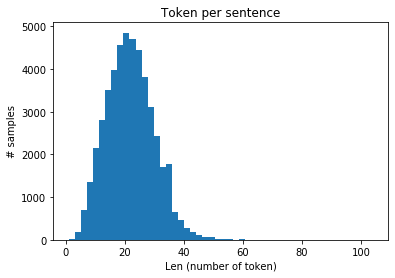

In [86]:
# Get all the sentences
sentences = getter.sentences
# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [87]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])
# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 19297
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 12
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [11271 34869  5228 12463 29588 19673 17797 21361 33005 27144 33539 22221
  7820  2061 22461 27144 17899 34869 19099 30513  1047 22761 29328 30245
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0

In [105]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tf2crf import CRF
# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

ModuleNotFoundError: No module named 'tf2crf'

## Named Entity Recognition (NER) with BERT in Spark NLP
from: https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

In [95]:
conda install pyspark

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - pyspark


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    py4j-0.10.7                |           py37_0         243 KB
    pyspark-2.4.0              |           py37_0       195.5 MB
    ------------------------------------------------------------
                                           Total:       195.7 MB

The following NEW packages will be INSTALLED:

  py4j               pkgs/main/osx-64::py4j-0.10.7-py37_0
  pyspark            pkgs/main/osx-64::pyspark-2.4.0-py37_0



pyspark-2.4.0        | 195.5 MB  | ##################################### | 100% 
py4j-0.10.7          | 243 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use upda

In [108]:
conda install -c johnsnowlabs spark-nlp

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - spark-nlp


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    spark-nlp-2.7.1            |           py37_0          31 KB  johnsnowlabs
    ------------------------------------------------------------
                                           Total:          31 KB

The following NEW packages will be INSTALLED:

  spark-nlp          johnsnowlabs/noarch::spark-nlp-2.7.1-py37_0



spark-nlp-2.7.1      | 31 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [109]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
import sparknlp
spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  2.7.1
Apache Spark version:  2.4.0


In [114]:
from sparknlp.training import CoNLL
#training_data = CoNLL().readDataset(spark, './eng.train')
#training_data.show()
CoNLL().readDataset()

TypeError: readDataset() missing 2 required positional arguments: 'spark' and 'path'

In [3]:
from sparknlp.training import POS
train_pos = POS().readDataset(spark, "./src/main/resources/anc-pos-corpus")

AttributeError: Cannot load _jvm from SparkContext. Is SparkContext initialized?

## References
- https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede
- https://www.youtube.com/watch?v=LFXsG7fueyk
- https://www.depends-on-the-definition.com/tags/named-entity-recognition/
    - https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/
- https://medium.com/@utkarsh.kumar2407/named-entity-recognition-using-bidirectional-lstm-crf-9f4942746b3c